In [2]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
print('check：libs well prepared')

check：libs well prepared


### 下載數據解壓縮

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  if not os.path.exists(filename):
    print('download...')
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print('exception %s' % statinfo.st_size)
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [5]:
words

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

### 將每個文字編碼

In [6]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  #每個詞出現的次數
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  #單詞映射到數字
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0 
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  #數字到單詞的映射
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

#映射完成後的訓練數據集
data, count, dictionary, reverse_dictionary = build_dataset(words)
#
print('Most common words (+UNK)', count[:5])
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [9]:
8 // 2

4

### 產生skip-gram訓練數據

In [11]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  # x y
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # context word context
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # 
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['what', 'what', 'this', 'this', 'means', 'means', 'anarchism', 'anarchism']
    labels: ['this', 'means', 'of', 'what', 'also', 'this', 'means', 'also']


In [11]:
print('data:', [reverse_dictionary[di] for di in data[:9]])
data_index = 0
batch, labels = generate_batch(batch_size=9, num_skips=3, skip_window=2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(9)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    batch: ['as', 'as', 'as', 'a', 'a', 'a', 'term', 'term', 'term']
    labels: ['originated', 'a', 'term', 'originated', 'of', 'term', 'abuse', 'a', 'of']


In [12]:
print('data:', [reverse_dictionary[di] for di in data[:9]])
data_index = 0
batch, labels = generate_batch(batch_size=9, num_skips=3, skip_window=3)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(9)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    batch: ['a', 'a', 'a', 'term', 'term', 'term', 'of', 'of', 'of']
    labels: ['abuse', 'as', 'term', 'as', 'abuse', 'a', 'used', 'a', 'first']


In [13]:
print('data:', [reverse_dictionary[di] for di in data[:9]])
data_index = 0
batch, labels = generate_batch(batch_size=9, num_skips=1, skip_window=1)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(9)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    batch: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
    labels: ['as', 'originated', 'term', 'a', 'abuse', 'of', 'used', 'first', 'used']


### 定義類神經網路

In [15]:
batch_size = 128
embedding_size = 128 # 
skip_window = 1 # 
num_skips = 2 # 
valid_size = 16 # 
valid_window = 100 #
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 #

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 輸入數據
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # 定義變量
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  #本次訓練數據對應的embedding
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # batch loss
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  #優化loss
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

### 開始進行類神經網路訓練

In [15]:
num_steps = 100000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps+1):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 8.106843
Nearest to american: falcons, interbreeding, guoyu, rhythmic, hypoglycemia,
Nearest to if: correlations, panthera, fein, gpc, anemometers,
Nearest to one: misrepresented, vinnie, puccini, caracalla, mundi,
Nearest to has: detergent, hyena, sears, dn, jezreel,
Nearest to s: blackout, esp, slightly, terrestrial, tailpiece,
Nearest to people: skeptical, conifers, deportation, freya, anaesthesia,
Nearest to world: inability, fontsize, steffi, rivaling, curiously,
Nearest to will: convolution, whites, zines, slocum, payable,
Nearest to be: cannes, mannered, usps, moretti, corinthians,
Nearest to two: expressive, baptised, vikrant, hologram, predation,
Nearest to about: worshipper, amish, allied, sending, branko,
Nearest to these: advisers, delphic, reinhold, piero, adc,
Nearest to but: domitius, listens, pan, coincidental, snake,
Nearest to six: rio, moncton, croesus, hereafter, alcatraz,
Nearest to by: polonaise, bubblegum, defoe, outlets, vulture,
Nearest 

Average loss at step 72000: 3.373201
Average loss at step 74000: 3.345545
Average loss at step 76000: 3.324226
Average loss at step 78000: 3.353305
Average loss at step 80000: 3.379028
Nearest to american: british, epidemic, german, french, international,
Nearest to if: when, though, then, before, where,
Nearest to one: seven, two, six, four, three,
Nearest to has: had, have, is, millimeter, was,
Nearest to s: arrhenius, isbn, ber, obscured, andy,
Nearest to people: men, jews, students, children, albinism,
Nearest to world: fontsize, tsarevich, uk, abbots, massawa,
Nearest to will: would, can, could, must, may,
Nearest to be: been, being, have, become, homogeneity,
Nearest to two: three, four, six, five, one,
Nearest to about: worshipper, burnley, over, exactly, almost,
Nearest to these: many, several, those, various, such,
Nearest to but: however, and, although, while, though,
Nearest to six: four, five, eight, seven, three,
Nearest to by: using, through, polonaise, mala, from,
Neares

In [19]:
valid_examples

array([22, 43, 18, 32, 74, 49, 17, 72, 83, 68, 85, 23, 27, 50, 25, 73])

In [17]:
reverse_dictionary[valid_examples[1]]

'other'

### 視覺化

In [16]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

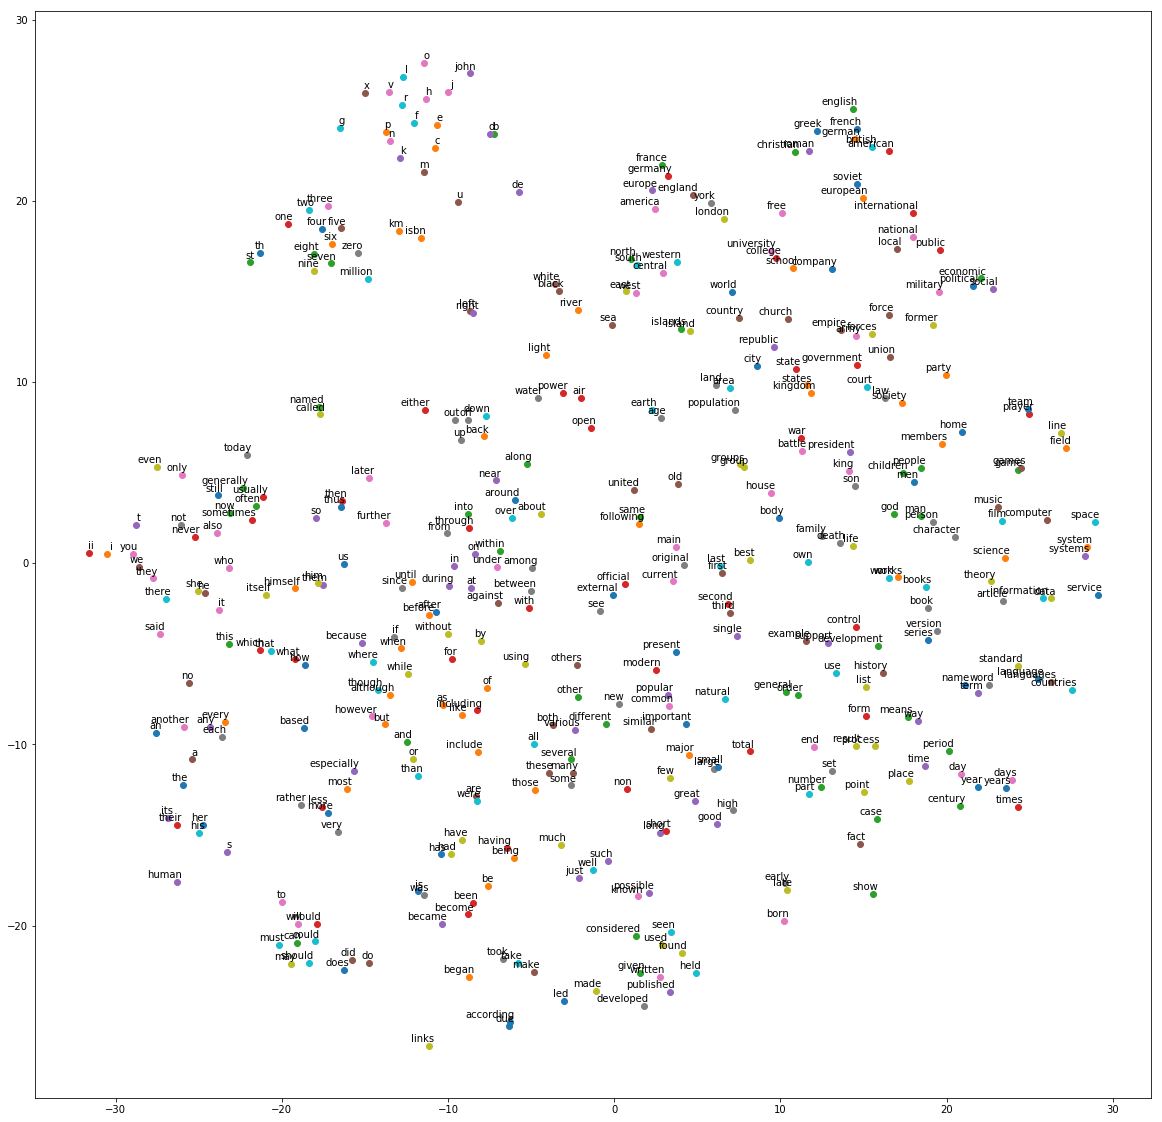

In [17]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)